## langgraph - 人机互动
***
- 基本运用：等待用户输入
- 基本运用：审查工具调用
- 基本使用：编辑图的状态


### 等待用户输入或介入
****
在节点与节点间增加人类反馈节点

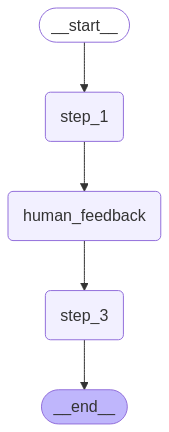

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str
    user_feedback: str


def step_1(state):
    print("---Step 1---")
    pass


def human_feedback(state):
    print("---human_feedback---")
    feedback = interrupt("Please provide feedback:")
    return {"user_feedback": feedback}


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
# Input
initial_input = {"input": "你好"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

---Step 1---
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value='Please provide feedback:', resumable=True, ns=['human_feedback:90f82932-04be-971f-eea2-d1366a5cfdd1']),)}




添加人类反馈

In [3]:
# 继续执行
for event in graph.stream(
    Command(resume="go to step 3!"), thread, stream_mode="updates"
):
    print(event)
    print("\n")

---human_feedback---
{'human_feedback': {'user_feedback': 'go to step 3!'}}


---Step 3---
{'step_3': None}




在智能体中引入人工介入环节

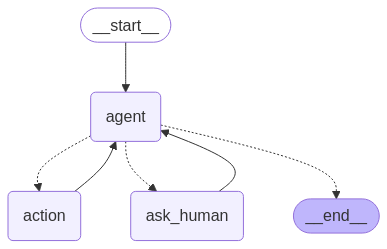

In [8]:
# 设置状态
from langgraph.graph import MessagesState, START

# 设置工具
# 我们将有一个真实工具 - 搜索工具
# 我们还将有一个"假"工具 - "ask_human"（询问人类）工具
# 这里我们定义任何实际工具
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def search(query: str):
    """调用此函数来浏览网络。"""
    # 这只是实际实现的占位符
    # 不要让大语言模型知道这一点哦 😊
    return f"我查询了：{query}。结果：北京天气晴朗，温度25度。"


tools = [search]
tool_node = ToolNode(tools)

# 设置模型
from langchain_deepseek import ChatDeepSeek
import os

model = ChatDeepSeek(
    model="Pro/deepseek-ai/DeepSeek-V3",
    temperature=0,
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    base_url=os.environ.get("DEEPSEEK_API_BASE"),
)

from pydantic import BaseModel


# 我们将"绑定"所有工具到模型
# 我们有上面的实际工具，但我们还需要一个模拟工具来询问人类
# 由于`bind_tools`接受工具但也接受工具定义，
# 我们可以为`ask_human`定义一个工具定义
class AskHuman(BaseModel):
    """向人类提问"""

    question: str


model = model.bind_tools(tools + [AskHuman])

# 定义节点和条件边


# 定义确定是否继续的函数
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # 如果没有函数调用，则结束
    if not last_message.tool_calls:
        return END
    # 如果工具调用是询问人类，我们返回该节点
    # 你也可以在这里添加逻辑，让某些系统知道有需要人类输入的内容
    # 例如，发送slack消息等
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # 否则如果有函数调用，我们继续
    else:
        return "action"


# 定义调用模型的函数
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # 我们返回一个列表，因为这将被添加到现有列表中
    return {"messages": [response]}


# 我们定义一个假节点来询问人类
def ask_human(state):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    ask = AskHuman.model_validate(state["messages"][-1].tool_calls[0]["args"])
    location = interrupt(ask.question)
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": location}]
    return {"messages": tool_message}


# 构建图

from langgraph.graph import END, StateGraph

# 定义一个新图
workflow = StateGraph(MessagesState)

# 定义我们将循环的三个节点
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

# 将入口点设置为`agent`
# 这意味着这个节点是第一个被调用的
workflow.add_edge(START, "agent")

# 现在添加一个条件边
workflow.add_conditional_edges(
    # 首先，我们定义起始节点。我们使用`agent`。
    # 这意味着这些是在调用`agent`节点后采取的边。
    "agent",
    # 接下来，我们传入将确定下一个调用哪个节点的函数。
    should_continue,
)

# 现在我们从`tools`到`agent`添加一个普通边。
# 这意味着在调用`tools`之后，下一步调用`agent`节点。
workflow.add_edge("action", "agent")

# 在我们获得人类响应后，我们回到代理
workflow.add_edge("ask_human", "agent")

# 设置内存
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# 最后，我们编译它！
# 这将它编译成一个LangChain Runnable，
# 意味着你可以像使用任何其他runnable一样使用它
# 我们在`ask_human`节点之前添加一个断点，所以它永远不会执行
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
config = {"configurable": {"thread_id": "2"}}
for event in app.stream(
    {
        "messages": [
            (
                "user",
                "询问用户他们在哪里，然后查询那里的天气",
            )
        ]
    },
    config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

询问用户他们在哪里，然后查询那里的天气
================================== Ai Message ==================================
Tool Calls:
  AskHuman (0195e74db433e3a9929cbe262e48703d)
 Call ID: 0195e74db433e3a9929cbe262e48703d
  Args:
    question: 你在哪里？我想查询那里的天气。


可以看到这个流被中断了，并在会一直等待人类的输入，来确认人类的地点

In [10]:
for event in app.stream(Command(resume="北京"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  AskHuman (0195e74db433e3a9929cbe262e48703d)
 Call ID: 0195e74db433e3a9929cbe262e48703d
  Args:
    question: 你在哪里？我想查询那里的天气。
================================= Tool Message =================================

北京
================================== Ai Message ==================================
Tool Calls:
  search (0195e74dbfa94f07c9c89ad0c7c949be)
 Call ID: 0195e74dbfa94f07c9c89ad0c7c949be
  Args:
    query: 北京天气
================================= Tool Message =================================
Name: search

我查询了：北京天气。结果：北京天气晴朗，温度25度。
================================== Ai Message ==================================

北京目前天气晴朗，温度为25度。


### 审查工具调用
****
人工介入智能体的工具调用过程，实现人机协同

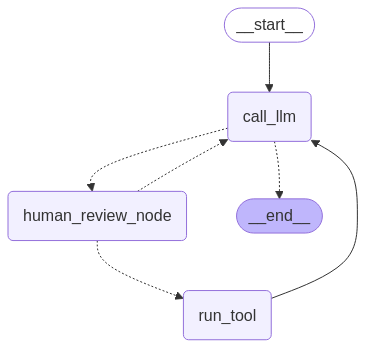

In [13]:
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_core.tools import tool
from langchain_core.messages import AIMessage
from IPython.display import Image, display


@tool
def weather_search(city: str):
    """搜索天气"""
    print("----")
    print(f"正在搜索：{city}")
    print("----")
    return "晴朗！"


# 设置模型
from langchain_deepseek import ChatDeepSeek
import os

deepseek = ChatDeepSeek(
    model="Pro/deepseek-ai/DeepSeek-V3",
    temperature=0,
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    base_url=os.environ.get("DEEPSEEK_API_BASE"),
)

model = deepseek.bind_tools(
    [weather_search]
)


class State(MessagesState):
    """简单状态。"""


def call_llm(state):
    return {"messages": [model.invoke(state["messages"])]}


def human_review_node(state) -> Command[Literal["call_llm", "run_tool"]]:
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[-1]

    # 这是我们将通过Command(resume=<human_review>)提供的值
    human_review = interrupt(
        {
            "question": "这是正确的吗？",
            # 显示工具调用以供审核
            "tool_call": tool_call,
        }
    )

    review_action = human_review["action"]
    review_data = human_review.get("data")

    # 如果批准，调用工具
    if review_action == "continue":
        return Command(goto="run_tool")

    # 更新AI消息并调用工具
    elif review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],
                    # 这是人类提供的更新
                    "args": review_data,
                }
            ],
            # 这很重要 - 这需要与你替换的消息相同！
            # 否则，它将显示为一个单独的消息
            "id": last_message.id,
        }
        return Command(goto="run_tool", update={"messages": [updated_message]})

    # 向LLM提供反馈
    elif review_action == "feedback":
        # 注意：我们将反馈消息添加为ToolMessage
        # 以保持消息历史中的正确顺序
        # （带有工具调用的AI消息需要后跟工具调用消息）
        tool_message = {
            "role": "tool",
            # 这是我们的自然语言反馈
            "content": review_data,
            "name": tool_call["name"],
            "tool_call_id": tool_call["id"],
        }
        return Command(goto="call_llm", update={"messages": [tool_message]})


def run_tool(state):
    new_messages = []
    tools = {"weather_search": weather_search}
    tool_calls = state["messages"][-1].tool_calls
    for tool_call in tool_calls:
        tool = tools[tool_call["name"]]
        result = tool.invoke(tool_call["args"])
        new_messages.append(
            {
                "role": "tool",
                "name": tool_call["name"],
                "content": result,
                "tool_call_id": tool_call["id"],
            }
        )
    return {"messages": new_messages}


def route_after_llm(state) -> Literal[END, "human_review_node"]:
    if len(state["messages"][-1].tool_calls) == 0:
        return END
    else:
        return "human_review_node"


builder = StateGraph(State)
builder.add_node(call_llm)
builder.add_node(run_tool)
builder.add_node(human_review_node)
builder.add_edge(START, "call_llm")
builder.add_conditional_edges("call_llm", route_after_llm)
builder.add_edge("run_tool", "call_llm")

# 设置内存
memory = MemorySaver()

# 添加
graph = builder.compile(checkpointer=memory)

# 查看
display(Image(graph.get_graph().draw_mermaid_png()))


当不涉及工具调用的时候，不会触发人工审核

In [ ]:
# Input
initial_input = {"messages": [{"role": "user", "content": "你好！"}]}

# Thread
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content='你好！有什么可以帮您的吗？😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 72, 'total_tokens': 82, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Pro/deepseek-ai/DeepSeek-V3', 'system_fingerprint': '', 'finish_reason': 'stop', 'logprobs': None}, id='run-d6e21c61-8191-4c11-b445-81c6cf8640ab-0', usage_metadata={'input_tokens': 72, 'output_tokens': 10, 'total_tokens': 82, 'input_token_details': {}, 'output_token_details': {}})]}}




一旦涉及到工具调用 就会触发人工介入

In [15]:
# Input
initial_input = {"messages": [{"role": "user", "content": "北京的天气如何?"}]}

# Thread
thread = {"configurable": {"thread_id": "2"}}

for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '0195e75e635a549ed6975331ce04f284', 'function': {'arguments': '{"city":"北京"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 74, 'total_tokens': 92, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Pro/deepseek-ai/DeepSeek-V3', 'system_fingerprint': '', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d8d99608-8d50-4e78-b84f-e51087c5d15d-0', tool_calls=[{'name': 'weather_search', 'args': {'city': '北京'}, 'id': '0195e75e635a549ed6975331ce04f284', 'type': 'tool_call'}], usage_metadata={'input_tokens': 74, 'output_tokens': 18, 'total_tokens': 92, 'input_token_details': {}, 'output_token_details': {}})]}}


{'__interrupt__': (Interrupt(value={'question': '这是正确的吗？', 'tool_call': {'name': 'weather_search', 'args': {'city': '北京'}, 'id': '0195e75e635a549ed6975331ce04f2

使用Command进行人机交互

In [16]:
for event in graph.stream(
    # 输入值
    Command(resume={"action": "continue"}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

{'human_review_node': None}


----
正在搜索：北京
----
{'run_tool': {'messages': [{'role': 'tool', 'name': 'weather_search', 'content': '晴朗！', 'tool_call_id': '0195e75e635a549ed6975331ce04f284'}]}}


{'call_llm': {'messages': [AIMessage(content='北京的天气是晴朗的！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 106, 'total_tokens': 112, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Pro/deepseek-ai/DeepSeek-V3', 'system_fingerprint': '', 'finish_reason': 'stop', 'logprobs': None}, id='run-533e1756-b31f-4af0-8535-99bb9828c2e6-0', usage_metadata={'input_tokens': 106, 'output_tokens': 6, 'total_tokens': 112, 'input_token_details': {}, 'output_token_details': {}})]}}




更进一步，对智能体调用的工具进行参数编辑

In [17]:
# Input
initial_input = {"messages": [{"role": "user", "content": "深圳的天气如何?"}]}

# Thread
thread = {"configurable": {"thread_id": "3"}}

for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '0195e763ebf746ef6ead6925e2f4d738', 'function': {'arguments': '{"city":"深圳"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 75, 'total_tokens': 93, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Pro/deepseek-ai/DeepSeek-V3', 'system_fingerprint': '', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0424c502-b71d-46be-8e21-f420381fab70-0', tool_calls=[{'name': 'weather_search', 'args': {'city': '深圳'}, 'id': '0195e763ebf746ef6ead6925e2f4d738', 'type': 'tool_call'}], usage_metadata={'input_tokens': 75, 'output_tokens': 18, 'total_tokens': 93, 'input_token_details': {}, 'output_token_details': {}})]}}


{'__interrupt__': (Interrupt(value={'question': '这是正确的吗？', 'tool_call': {'name': 'weather_search', 'args': {'city': '深圳'}, 'id': '0195e763ebf746ef6ead6925e2f4d7

In [18]:
# 直接对工具的参数进行编辑
for event in graph.stream(
    Command(resume={"action": "update", "data": {"city": "上海,中国"}}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

{'human_review_node': {'messages': [{'role': 'ai', 'content': '', 'tool_calls': [{'id': '0195e763ebf746ef6ead6925e2f4d738', 'name': 'weather_search', 'args': {'city': '上海,中国'}}], 'id': 'run-0424c502-b71d-46be-8e21-f420381fab70-0'}]}}


----
正在搜索：上海,中国
----
{'run_tool': {'messages': [{'role': 'tool', 'name': 'weather_search', 'content': '晴朗！', 'tool_call_id': '0195e763ebf746ef6ead6925e2f4d738'}]}}


{'call_llm': {'messages': [AIMessage(content='深圳的天气是晴朗的！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 118, 'total_tokens': 125, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Pro/deepseek-ai/DeepSeek-V3', 'system_fingerprint': '', 'finish_reason': 'stop', 'logprobs': None}, id='run-995428f3-4bb4-4468-a144-2abbd298c62e-0', usage_metadata={'input_tokens': 118, 'output_tokens': 7, 'total_tokens': 125, 'input_token_details': {}, 'output_token_details': {}})]}}




### 人机交互 - 对图状态进行编辑
****
使用断点对节点间的消息进行人工干预
![](langgraph3.png)

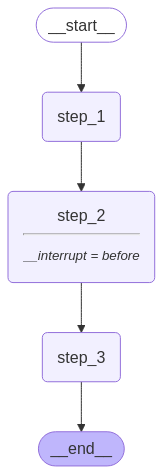

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str


def step_1(state):
    print("---Step 1---")
    pass


def step_2(state):
    print("---Step 2---")
    pass


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add 注意interrupt_before
graph = builder.compile(checkpointer=memory, interrupt_before=["step_2"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
# Input
initial_input = {"input": "你好"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'input': '你好'}
---Step 1---


此时可以人工介入

In [21]:
graph.update_state(thread, {"input": "你好 1goto.ai!"})
print("---\n---\nUpdated state!")
print(graph.get_state(thread).values)

---
---
Updated state!
{'input': '你好 1goto.ai!'}


In [22]:
# 继续执行
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

{'input': '你好 1goto.ai!'}
---Step 2---
---Step 3---
